# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Luis Saez Diaz
+ Erwin Nuñez Bracho

**Correos Electrónicos:**

+ lu.saezd@duocuc.cl
+ er.nunez@duocuc.cl

**Fecha de Creación:** 07 de Abril de 2025  
**Versión:** 0.5  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python, keras y tensorflow para el manejo de las redes neuronales y el matplotlib para la creacion de graficos con python.

# Carga de datos

In [1]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-18 17:12:42--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  22.5MB/s    in 0.4s    

2025-04-18 17:12:42 (22.5 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-18 17:12:43--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [applica

In [2]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [3]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga de imágenes

In [4]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La cantidad de datos en la muestra de entrenamiento es de 60.000 datos,
al vectorizarlos (aplanar) nos queda que las imagenes representan 784 pixeles vectorizados. En el caso de nuestra muestra de evaluación tenemos 10.000
con la misma cantidad de pixeles vectorizados y en el caso de las etiquetas tenemos que son 10.

Posteriormente a la carga los datos son normalizados, re-ajustando sus valores en valores de 0 a 255 lo que permite que todos mantengan un mismo rango de valores (formato) y no hayas valores que se disparen a diferencia de los demas.

# Muestra imágenes

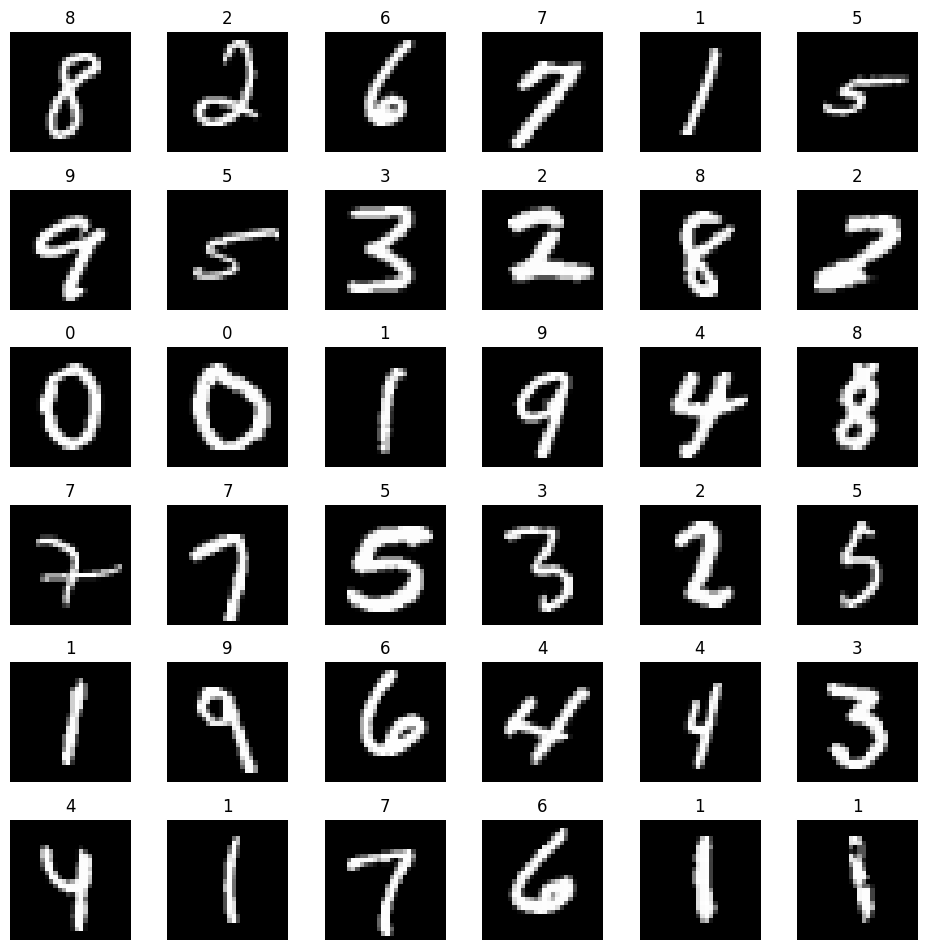

In [5]:
h, w = 6, 6  # tamaño de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h, 1.6*w))

for i in range(h):
    for j in range(w):
        idx = np.random.randint(len(X_train))  # índice aleatorio
        img = X_train[idx].reshape(28, 28)  # redimensionar imagen
        label = np.argmax(y_train[idx])     # obtener etiqueta

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(str(label))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Hacemos una muestra aleatoria de los datos y sus etiquetas de nuestro set de datos de entrenamiento donde podemos ver que es un set de datos que contiene imagenes en blanco y negro de numeros del 0 al 9. **[PREGUNTAR PORQUE USA EL NP SET SEED]**

# Red neuronal 1: Optimizador Adamax

## Red base

Para esta fase de experimentación, siendo que nuestros datos no tienen una gran dispersion ya que trabajan unicamente con 2 colores, se tomo la decision de utilizar los optimizadores de Adamax y Nadam, adamax siendo la mejora del optimizador adam que suele tener buen rendimiento en la mayoria de los casos y Nadam siendo el optimizador adam pero agregandole momentum. Esto nos permitira saber como se comporta nuestra red neuronal con un optimizador que posea momentum y nos permita optimizar los tiempos en los que ajusta los pesos.

en el caso de la funcion de perdida utilizaremos **categorical crossentropy** ya que es la que se comporta mejor con datos que esten en formato one hot enconding, en este caso nuestras clases estan formateadas de esa forma.

In [6]:
input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])

784
10


Evaluamos cuantas neuronas tendra la capa de entrada (784) y la capa de salida (10) correspondiente a la cantidad de datos que entraran y la cantidad de clases con las que debera responder la red neuronal.

In [8]:
h1 = 512
h2 = 256
h3 = 128
h4 = 64

red_adamax = keras.Sequential(name="AdamxNetworkBase")
red_adamax.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_adamax.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_adamax.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_adamax.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_adamax.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax.summary()

red_adamax.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)


Model: "AdamxNetworkBase"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

La precision y el recall, su interpretacion, habla sobre clase positiva y clase negativa haciendo alucion a un modelo de prediccion binario, es decir que solo tiene 2 clases. En este caso nuestro modelo es multi-clase por lo que estas metricas pierden total relevancia dado el enfoque de nuestro modelo.

In [ ]:
hist = red_adamax.fit(X_train, y_train,
        epochs=10,
        batch_size=1,
        validation_data=(X_test,y_test)
       )
red_adamax.save("AdamxNetworkBase.h5")

Epoch 1/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 439s 7ms/step - accuracy: 0.8966 - loss: 0.3324 - val_accuracy: 0.9599 - val_loss: 0.1384
Epoch 2/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 431s 7ms/step - accuracy: 0.9738 - loss: 0.0872 - val_accuracy: 0.9731 - val_loss: 0.0938
Epoch 3/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 448s 7ms/step - accuracy: 0.9830 - loss: 0.0575 - val_accuracy: 0.9757 - val_loss: 0.0878
Epoch 4/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 438s 7ms/step - accuracy: 0.9867 - loss: 0.0451 - val_accuracy: 0.9819 - val_loss: 0.0714
Epoch 5/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 445s 7ms/step - accuracy: 0.9910 - loss: 0.0329 - val_accuracy: 0.9799 - val_loss: 0.0809
Epoch 6/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 452s 7ms/step - accuracy: 0.9932 - loss: 0.0255 - val_accuracy: 0.9815 - val_loss: 0.0855
Epoch 7/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 428s 7ms/step - accuracy: 0.9946 - loss: 0.0205 - val_accuracy: 0.9800 - val_loss: 0.0954
Epoch 8/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 430s 7ms/step - ac

Se hace el entrenamiento de la red neuronal base utilizando 10 epocas y sin aplicar agrupaciones (batch size) esto para evaluar el comportamiento del modelo con todas las entradas, sin aplicar segmentacion.

Como podemos observar en la epoca 5 el rendimiento tanto en training como en testing sigue aumentando sin haber una diferencia notable pero la perdida en la fase de testing empieza a aumentar quedando asi una diferencia algo notable en la epoca 10 en ambas perdidas.

Accuracy: 99.71% (Training) / 98.29% (testing) -> 1.42% de diferencia

Perdida: 0.0098 / 0.1143 -> 0.1045 diferencia de perdidas

Esto indica que el modelo base, al no presentar una diferencia notable entre el rendimiento durante el training y el testing se puede decir que esta generalizando de manera casi "perfecta", pese a esto se continuara con la experimentacion de distintos factores de la red neuronal para evaluar su comportamiento.

## Experimento 1: Aumento de batch Size

In [ ]:
hist = red_adamax.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_adamax.save("AdamxExp1.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - accuracy: 0.9986 - loss: 0.0049 - val_accuracy: 0.9814 - val_loss: 0.1146
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9813 - val_loss: 0.1219
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9842 - val_loss: 0.1175
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9998 - loss: 8.4147e-04 - val_accuracy: 0.9838 - val_loss: 0.1270
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.9997 - loss: 7.6836e-04 - val_accuracy: 0.9828 - val_loss: 0.1321
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9999 - loss: 4.3306e-04 - val_accuracy: 0.9828 - val_loss: 0.1335
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.9998 - loss: 5.1962e-04 - val_accuracy: 0.9840 - val_loss: 0.1369
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 

Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso ya en la epoca 3 se empieza a notar un aumento en la perdida y baja en la presicion del testing, se utilizara los resultados de la epoca 4 como evaluacion ya que es la ultima epoca en donde el modelo no empieza a perder rendimiento.

Accuracy: 99.97% (Training) / 98.42% (testing) -> 1.55% de diferencia

Perdida: 0.0011 / 0.1315 -> 0.1304 diferencia de perdidas

Como podemos ver el rendimiento del modelo, de nuestro primer experimento, se vio afectado negativamente ya que aumento ligeramente la diferencia tanto de perdida como de precision entre la fase de training y testing.

Aun asi, viendo que la diferencia no es tan alta se utilizara el batch size de 10 para los siguientes experimentos, esto con el fin de poder optimizar el tiempo de entrenamiento de la red neuronal.

## Experimento 2: Funcion de activacion Elu

In [9]:
red_adamax = keras.Sequential(name="AdamxNetworkBase")
red_adamax.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax.add(keras.layers.Dense(h1, activation='elu', name='hide_layer1'))
red_adamax.add(keras.layers.Dense(h2, activation='elu', name='hide_layer2'))
red_adamax.add(keras.layers.Dense(h3, activation='elu', name='hide_layer3'))
red_adamax.add(keras.layers.Dense(h4, activation='elu', name='hide_layer4'))
red_adamax.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax.summary()

red_adamax.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "AdamxNetworkBase"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

En este experimento se realizo una modificacion en la funcion de activacion de las capas ocultas, esto con el fin de evaluar si el rendimiento se ve afectado debido a que el calculo matematico que realiza la red en el entrenamiento (para calcular los pesos) esta dando 0 lo que indica que la neurona queda "muerta".

In [10]:
hist = red_adamax.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_adamax.save("AdamxExp2.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.8964 - loss: 0.3358 - val_accuracy: 0.9582 - val_loss: 0.1298
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9680 - loss: 0.1048 - val_accuracy: 0.9684 - val_loss: 0.0992
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.9774 - loss: 0.0728 - val_accuracy: 0.9735 - val_loss: 0.0776
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9825 - loss: 0.0538 - val_accuracy: 0.9742 - val_loss: 0.0820
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.9866 - loss: 0.0426 - val_accuracy: 0.9777 - val_loss: 0.0708
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.9897 - loss: 0.0338 - val_accuracy: 0.9784 - val_loss: 0.0717
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 90s 10ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9791 - val_loss: 0.0712
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9937 - loss:

Luego de aplicar el cambio en la funcion de activacion se puede observar fluctuaciones de perdida disparejas en cada epoca, en vez de ir aumentando o disminuyendo en cada epoca, va fluctuando hacia arriba y hacia abajo en cada una.

Accuracy: 99.55% (Training) / 97.95% (testing) -> 2% de diferencia

Perdida: 0.0098 / 0.1143 -> 0.0659 diferencia de perdidas

Tomando los resultados de la ultima epoca podemos observar que al aplicar el cambio en la funcion de activacion aumenta ligeramente la diferencia de precision entre la fase de training y testing, siendo esta de un 2% pero se disminuye considerablemente la diferencia de perdida entre ambas fases (Siendo mas relevante la disminucion de la perdida en la fase de testing).

## Experimento 3: Anexo de una capa oculta extra

In [ ]:
h1 = 512
h2 = 256
h3 = 128
h4 = 64
h5 = 32

red_adamax_exp3 = keras.Sequential(name="AdamxNetworkExp3")
red_adamax_exp3.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax_exp3.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_adamax_exp3.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_adamax_exp3.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_adamax_exp3.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_adamax_exp3.add(keras.layers.Dense(h5, activation='relu', name='hide_layer5'))
red_adamax_exp3.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax_exp3.summary()

red_adamax_exp3.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "AdamxNetworkExp3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer5 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,810 (2.20 MB)

 Trainable params: 576,810 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

En este experimento se anexo de una capa oculta lo que puede permitir el refinamiento del aprendizaje de la red neuronal ya que le permitira aprender patrones mas complejos al aplicar otra fase de procesamiento de datos.

In [ ]:
hist = red_adamax_exp3.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_adamax_exp3.save("AdamxExp3.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.8652 - loss: 0.4451 - val_accuracy: 0.9639 - val_loss: 0.1241
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9688 - loss: 0.1023 - val_accuracy: 0.9684 - val_loss: 0.1096
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9806 - loss: 0.0649 - val_accuracy: 0.9755 - val_loss: 0.0779
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.9864 - loss: 0.0443 - val_accuracy: 0.9736 - val_loss: 0.0934
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9911 - loss: 0.0301 - val_accuracy: 0.9790 - val_loss: 0.0808
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9936 - loss: 0.0210 - val_accuracy: 0.9783 - val_loss: 0.0812
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9952 - loss: 0.0158 - val_accuracy: 0.9813 - val_loss: 0.0723
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9966 - loss: 0

Como se puede observar el rendimiento en la fase de testing, junto a su perdida, se vio afectado negativamente a partir de la epoca numero 8 por lo que se tomo la decision de realizar la evalucion de la red neuronal tomando las metricas de esa epoca.

Accuracy: 99.75% (Training) / 98.32% (testing) -> 1.43% de diferencia

Perdida: 0.0087 / 0.0641 -> 0.554 diferencia de perdidas

como podemos observar, al agregar una capa oculta a nuestra red neuronal y volviendo a utilizar la funcion de activacion **relu** se puede ver una mejoria en el rendimiento del modelo ya que no se sacrifica tanta precision como en experimentos anteriores pero se ve una diferencia y disminucion notable en la perdida de ambas fases (training & testing) esto puede deberse a que la red neuronal, con una capa oculta extra, esta identificando patrones mas complejos en nuestros datos lo que permite que entregue una respuesta mas acertada.

## Experimento 4: Aumento de neuronas

In [ ]:
h1 = 1024
h2 = 512
h3 = 256
h4 = 128

red_adamax_exp4 = keras.Sequential(name="AdamxNetworkChangeNeuronal")
red_adamax_exp4.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax_exp4.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_adamax_exp4.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_adamax_exp4.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_adamax_exp4.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_adamax_exp4.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax_exp4.summary()

red_adamax_exp4.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "AdamxNetworkChangeNeuronal"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,494,154 (5.70 MB)

 Trainable params: 1,494,154 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

En este experimento se tomo la decision de duplicar las neuronas de cada una de las 4 capas ocultas, esto con el fin de poder entregar mas memoria a la red neuronal y permitira una mayor capacidad de analisis de cada uno de los datos que vienen en nuestra muestra.

In [ ]:
hist = red_adamax_exp4.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_adamax_exp4.save("AdamxExp4.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - accuracy: 0.9019 - loss: 0.3155 - val_accuracy: 0.9700 - val_loss: 0.0942
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - accuracy: 0.9760 - loss: 0.0770 - val_accuracy: 0.9755 - val_loss: 0.0778
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - accuracy: 0.9863 - loss: 0.0438 - val_accuracy: 0.9795 - val_loss: 0.0637
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 145s 17ms/step - accuracy: 0.9920 - loss: 0.0264 - val_accuracy: 0.9802 - val_loss: 0.0710
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.9949 - loss: 0.0165 - val_accuracy: 0.9807 - val_loss: 0.0717
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9829 - val_loss: 0.0657
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9823 - val_loss: 0.0740
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - accuracy: 

En este caso notamos que el rendimiento, como ocurrio en el experimento donde se aumentaron las capas ocultas, tiene fluctuaciones.

Accuracy: 99.92% (Training) / 98.38% (testing) -> 1.54% de diferencia

Perdida: 0.0036 / 0.0641 -> 0.0792 diferencia de perdidas

En este caso aumento la diferencia entre la precision de training & testing junto a la diferencia de perdida de ambas fases. Esto puede deberse al hecho de que la muestra que se esta utilizando no posee tanta variabilidad ni mucha complejidad en sus datos y el aumentar las neuronas solo ocasiono que aumente el rudio lo que puede influir negativamente en el rendimiento del modelo.

## Experimento 5: Apagado de neuronas

In [ ]:
h1 = 512
h2 = 256
h3 = 128
h4 = 64
h5 = 32

red_adamax_exp5 = keras.Sequential(name="AdamxNetworkExp5")
red_adamax_exp5.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax_exp5.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_adamax_exp5.add(keras.layers.Dropout(0.2))
red_adamax_exp5.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_adamax_exp5.add(keras.layers.Dropout(0.2))
red_adamax_exp5.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_adamax_exp5.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_adamax_exp5.add(keras.layers.Dense(h5, activation='relu', name='hide_layer5'))
red_adamax_exp5.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax_exp5.summary()

red_adamax_exp5.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "AdamxNetworkExp5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer5 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,810 (2.20 MB)

 Trainable params: 576,810 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

En este ultimo experimento se tomo la decision de aplicar un apagado del 20% de neuronas en la capa oculta 1 y 2 para ver como se comporta el modelo.

In [ ]:
hist = red_adamax_exp5.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_adamax_exp5.save("AdamxExp5.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.8385 - loss: 0.5198 - val_accuracy: 0.9633 - val_loss: 0.1273
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9590 - loss: 0.1352 - val_accuracy: 0.9719 - val_loss: 0.0928
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9699 - loss: 0.0952 - val_accuracy: 0.9760 - val_loss: 0.0793
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9789 - loss: 0.0698 - val_accuracy: 0.9794 - val_loss: 0.0707
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9829 - loss: 0.0579 - val_accuracy: 0.9789 - val_loss: 0.0710
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.9846 - loss: 0.0474 - val_accuracy: 0.9815 - val_loss: 0.0646
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9878 - loss: 0.0386 - val_accuracy: 0.9813 - val_loss: 0.0689
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9886 - loss: 0

En este caso tambien se puede observar fluctuaciones en el rendimiento de ambas fases, donde a partir de la epoca 4 en rendimiento empieza a decaer por ende utilizaremos esta epoca para la evaluacion.

Accuracy: 99.96% (Training) / 98.48% (testing) -> 1.48% de diferencia

Perdida: 0.0011 / 0.1016 -> 0.1005 diferencia de perdidas

como se puede observar el rendimiento general del modelo se vio afectado negativamente, esto puede ser debido a que al aplicarse a capas tempranas se elimina informacion importante que estas pueden entregar a las capas sub-siguientes ademas el la tecnica de dropout es ideal para eviar el sobreajuste, lo cual no se observa en esta muestra de datos ya que no hay una diferencia notoria en la fase de training y testing.

# Red neuronal 1: Optimizador Nadam

## Red base

In [ ]:
input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])
h1 = 512
h2 = 256
h3 = 128
h4 = 64

red_nadam = keras.Sequential(name="NadamNetwork")
red_nadam.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_nadam.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_nadam.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_nadam.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_nadam.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam.summary()

red_nadam.compile(
    loss='categorical_crossentropy',
    optimizer='Nadam',
    metrics=['accuracy']
)

784
10


Model: "NadamNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = red_nadam.fit(X_train, y_train,
        epochs=10,
        batch_size=1,
        validation_data=(X_test,y_test)
       )
red_nadam.save("NadamNetwork.h5")

Epoch 1/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 495s 8ms/step - accuracy: 0.8778 - loss: 0.4428 - val_accuracy: 0.9575 - val_loss: 0.1890
Epoch 2/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 506s 8ms/step - accuracy: 0.9508 - loss: 0.2307 - val_accuracy: 0.9639 - val_loss: 0.1960
Epoch 3/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 514s 8ms/step - accuracy: 0.9563 - loss: 0.2226 - val_accuracy: 0.9613 - val_loss: 0.2386
Epoch 4/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 549s 8ms/step - accuracy: 0.9556 - loss: 0.2451 - val_accuracy: 0.9588 - val_loss: 0.3142
Epoch 5/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 513s 8ms/step - accuracy: 0.9488 - loss: 0.3130 - val_accuracy: 0.9419 - val_loss: 0.6227
Epoch 6/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 508s 8ms/step - accuracy: 0.9372 - loss: 0.3504 - val_accuracy: 0.9419 - val_loss: 0.6353
Epoch 7/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 557s 8ms/step - accuracy: 0.9151 - loss: 0.4730 - val_accuracy: 0.9038 - val_loss: 0.8152
Epoch 8/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 548s 8ms/step - ac

En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

La precision y el recall, su interpretacion, habla sobre clase positiva y clase negativa haciendo alucion a un modelo de prediccion binario, es decir que solo tiene 2 clases. En este caso nuestro modelo es multi-clase por lo que estas metricas pierden total relevancia dado el enfoque de nuestro modelo.

##Experimento 1: Aumento de batch Size

In [ ]:
hist = red_nadam.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_nadam.save("NadamExp1.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - accuracy: 0.9033 - loss: 0.3261 - val_accuracy: 0.9617 - val_loss: 0.1354
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9671 - loss: 0.1115 - val_accuracy: 0.9692 - val_loss: 0.1221
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9774 - loss: 0.0789 - val_accuracy: 0.9716 - val_loss: 0.1134
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9821 - loss: 0.0633 - val_accuracy: 0.9757 - val_loss: 0.0967
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9842 - loss: 0.0528 - val_accuracy: 0.9808 - val_loss: 0.0777
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9869 - loss: 0.0454 - val_accuracy: 0.9753 - val_loss: 0.1358
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9880 - loss: 0.0447 - val_accuracy: 0.9774 - val_loss: 0.1030
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.9905 - loss: 

Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso podemos apreciar que la pérdida disminuye de forma constante y progresiva, lo que indica un mejor rendimiento al aumentar el batch size.

Accuracy: 99.18% (Training) / 98.26% (testing) -> 0.92% de diferencia

Perdida: 0.0306 / 0.0972 -> 0.0666 diferencia de perdidas

Gracias a los datos observados, se aprecia una mejora en el rendimiento general tanto en testing como en training, por lo que se continuará con un batch size de 10.

##Experimento 2: Funcion de activacion Elu

In [ ]:
red_nadam = keras.Sequential(name="NadamNetwork")
red_nadam.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam.add(keras.layers.Dense(h1, activation='elu', name='hide_layer1'))
red_nadam.add(keras.layers.Dense(h2, activation='elu', name='hide_layer2'))
red_nadam.add(keras.layers.Dense(h3, activation='elu', name='hide_layer3'))
red_nadam.add(keras.layers.Dense(h4, activation='elu', name='hide_layer4'))
red_nadam.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam.summary()

red_nadam.compile(
    loss='categorical_crossentropy',
    optimizer='Nadam',
    metrics=['accuracy']
)

Model: "NadamNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = red_nadam.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_nadam.save("NadamExp2.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - accuracy: 0.8887 - loss: 0.3658 - val_accuracy: 0.9458 - val_loss: 0.1983
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9567 - loss: 0.1484 - val_accuracy: 0.9590 - val_loss: 0.1410
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9695 - loss: 0.1016 - val_accuracy: 0.9677 - val_loss: 0.1189
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9759 - loss: 0.0820 - val_accuracy: 0.9741 - val_loss: 0.0970
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9793 - loss: 0.0729 - val_accuracy: 0.9694 - val_loss: 0.1094
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9822 - loss: 0.0715 - val_accuracy: 0.9791 - val_loss: 0.0759
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9857 - loss: 0.0648 - val_accuracy: 0.9703 - val_loss: 0.1158
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9876 - loss: 

En este experimento se realizo una modificacion en la funcion de activacion de las capas ocultas, esto con el fin de evaluar si el rendimiento se ve afectado debido a que el calculo matematico que realiza la red en el entrenamiento (para calcular los pesos) esta dando 0 lo que indica que la neurona queda "muerta".

##Experimento 3: Anexo de una capa oculta extra

In [ ]:
h1 = 512
h2 = 256
h3 = 128
h4 = 64
h5 = 32

red_nadam_exp3 = keras.Sequential(name="NadamNetworkExp3")
red_nadam_exp3.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam_exp3.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_nadam_exp3.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_nadam_exp3.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_nadam_exp3.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_nadam_exp3.add(keras.layers.Dense(h5, activation='relu', name='hide_layer5'))
red_nadam_exp3.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam_exp3.summary()

red_nadam_exp3.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "NadamNetworkExp3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer5 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,810 (2.20 MB)

 Trainable params: 576,810 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = red_nadam_exp3.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_nadam_exp3.save("NadamExp3.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.8784 - loss: 0.4126 - val_accuracy: 0.9642 - val_loss: 0.1151
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9695 - loss: 0.1020 - val_accuracy: 0.9707 - val_loss: 0.0970
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.9808 - loss: 0.0629 - val_accuracy: 0.9760 - val_loss: 0.0749
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9883 - loss: 0.0388 - val_accuracy: 0.9757 - val_loss: 0.0823
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.9910 - loss: 0.0279 - val_accuracy: 0.9823 - val_loss: 0.0620
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.9940 - loss: 0.0192 - val_accuracy: 0.9804 - val_loss: 0.0758
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9960 - loss: 0.0130 - val_accuracy: 0.9805 - val_loss: 0.0757
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - accuracy: 0.9974 - loss: 0

En este experimento se anexo de una capa oculta lo que puede permitir el refinamiento del aprendizaje de la red neuronal ya que le permitira aprender patrones mas complejos al aplicar otra fase de procesamiento de datos.

##Experimento 4: Aumento de neuronas

In [ ]:
h1 = 1024
h2 = 512
h3 = 256
h4 = 128

red_nadam_exp4 = keras.Sequential(name="NadamNetworkChangeNeuronal")
red_nadam_exp4.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam_exp4.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_nadam_exp4.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_nadam_exp4.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_nadam_exp4.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_nadam_exp4.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam_exp4.summary()

red_nadam_exp4.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "NadamNetworkChangeNeuronal"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,494,154 (5.70 MB)

 Trainable params: 1,494,154 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = red_nadam_exp4.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_nadam_exp4.save("NadamExp4.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 105s 17ms/step - accuracy: 0.8983 - loss: 0.3276 - val_accuracy: 0.9683 - val_loss: 0.0982
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - accuracy: 0.9761 - loss: 0.0790 - val_accuracy: 0.9764 - val_loss: 0.0760
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 154s 19ms/step - accuracy: 0.9862 - loss: 0.0445 - val_accuracy: 0.9799 - val_loss: 0.0702
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 125s 21ms/step - accuracy: 0.9922 - loss: 0.0255 - val_accuracy: 0.9822 - val_loss: 0.0645
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - accuracy: 0.9949 - loss: 0.0164 - val_accuracy: 0.9807 - val_loss: 0.0723
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 138s 17ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9828 - val_loss: 0.0717
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 137s 17ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9834 - val_loss: 0.0709
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - accuracy: 

En este experimento se tomo la decision de duplicar las neuronas de cada una de las 4 capas ocultas, esto con el fin de poder entregar mas memoria a la red neuronal y permitira una mayor capacidad de analisis de cada uno de los datos que vienen en nuestra muestra.

##Experimento 5: Apagado de neuronas

In [ ]:
h1 = 512
h2 = 256
h3 = 128
h4 = 64
h5 = 32

red_nadam_exp5 = keras.Sequential(name="NadamNetworkExp5")
red_nadam_exp5.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam_exp5.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_nadam_exp5.add(keras.layers.Dropout(0.2))
red_nadam_exp5.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_nadam_exp5.add(keras.layers.Dropout(0.2))
red_nadam_exp5.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_nadam_exp5.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_nadam_exp5.add(keras.layers.Dense(h5, activation='relu', name='hide_layer5'))
red_nadam_exp5.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam_exp5.summary()

red_nadam_exp5.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

Model: "NadamNetworkExp5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer5 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,810 (2.20 MB)

 Trainable params: 576,810 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = red_nadam_exp5.fit(X_train, y_train,
        epochs=10,
        batch_size=10,
        validation_data=(X_test,y_test)
       )
red_nadam_exp5.save("NadamExp5.h5")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.8414 - loss: 0.5125 - val_accuracy: 0.9588 - val_loss: 0.1373
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.9590 - loss: 0.1392 - val_accuracy: 0.9708 - val_loss: 0.0929
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9726 - loss: 0.0939 - val_accuracy: 0.9759 - val_loss: 0.0795
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9787 - loss: 0.0701 - val_accuracy: 0.9778 - val_loss: 0.0705
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9822 - loss: 0.0580 - val_accuracy: 0.9791 - val_loss: 0.0749
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9843 - loss: 0.0486 - val_accuracy: 0.9788 - val_loss: 0.0738
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9874 - loss: 0.0394 - val_accuracy: 0.9813 - val_loss: 0.0699
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9889 - loss: 0

En este ultimo experimento se tomo la decision de aplicar un apagado del 20% de neuronas en la capa oculta 1 y 2 para ver como se comporta el modelo.